In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_percentage_error
from deap import base, creator, tools, algorithms

In [2]:
SEED = 42
np.random.seed(SEED)

data = pd.read_csv('DATA_DESA.csv')

df = pd.DataFrame(data)

# Normalisasi MinMax
scaler = MinMaxScaler()
df['jumlah_kecelakaan'] = scaler.fit_transform(df[['jumlah_kecelakaan']])

# Menambahkan kolom lag (pergeseran)
df['jumlah_kecelakaan_lag'] = df['jumlah_kecelakaan'].shift(1)
df = df.dropna() # Menghapus baris dengan nilai NaN

In [3]:
# Memisahkan data latih dan data uji sesuai rasio (0.8 untuk 80:20)
train_size = int(0.8 * len(df))
train_data = df.iloc[:train_size]
test_data = df.iloc[train_size:]

# Memisahkan fitur dan target untuk data latih
X_train = train_data['jumlah_kecelakaan_lag'].values.reshape(-1, 1)
y_train = train_data['jumlah_kecelakaan'].values

# Memisahkan fitur dan target untuk data uji
X_test = test_data['jumlah_kecelakaan_lag'].values.reshape(-1, 1)
y_test = test_data['jumlah_kecelakaan'].values

In [4]:
# Define evaluation function
def evaluate(individual):
    C, epsilon = individual
    if C <= 0 or epsilon <= 0:
        return float('inf'),
    svr = SVR(kernel='linear', C=C, epsilon=epsilon)
    svr.fit(X_train, y_train)
    y_pred = svr.predict(X_test)
    mape = mean_absolute_percentage_error(y_test, y_pred) * 100
    return mape,
    
# Setup DEAP framework
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()

# Parameter ranges
parameter_ranges = [(0.0001, 50), (1e-07, 5)]

# Register genetic operators
toolbox.register("attr_float", random.uniform)
toolbox.register("individual", tools.initCycle, creator.Individual, 
                 (lambda: random.uniform(*parameter_ranges[0]),
                  lambda: random.uniform(*parameter_ranges[1])), n=1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("mate", tools.cxUniform, indpb=0.1)  # Menggunakan crossover uniform
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)  # Menggunakan mutasi flipbit
toolbox.register("select", tools.selTournament, tournsize=3) # Menggunakan seleksi turnamen
toolbox.register("evaluate", evaluate)

MAPE terbaik untuk crossover_rate=0, mutation_rate=1: 57.69795835972307
MAPE terbaik untuk crossover_rate=0.1, mutation_rate=0.9: 57.69795835972307
MAPE terbaik untuk crossover_rate=0.2, mutation_rate=0.8: 57.69795835972307
MAPE terbaik untuk crossover_rate=0.3, mutation_rate=0.7: 57.69795835972307
MAPE terbaik untuk crossover_rate=0.4, mutation_rate=0.6: 57.69795835972307
MAPE terbaik untuk crossover_rate=0.5, mutation_rate=0.5: 57.69795835972307
MAPE terbaik untuk crossover_rate=0.6, mutation_rate=0.4: 57.69795835972307
MAPE terbaik untuk crossover_rate=0.7, mutation_rate=0.3: 57.69795835972307
MAPE terbaik untuk crossover_rate=0.8, mutation_rate=0.2: 57.69795835972305
MAPE terbaik untuk crossover_rate=0.9, mutation_rate=0.1: 57.69795835972305
MAPE terbaik untuk crossover_rate=1, mutation_rate=0: 57.69795835972305

Kombinasi optimal:
Crossover rate terbaik: 0.8
Mutation rate terbaik: 0.2
MAPE terbaik: 57.69795835972305


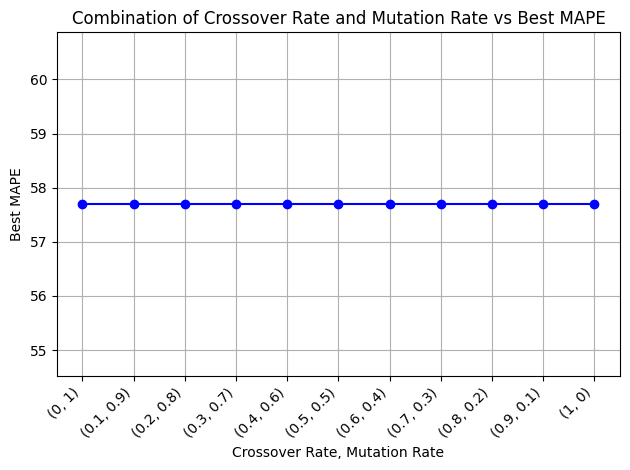

In [5]:
def main():
    crossover_rates = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
    mutation_rates = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0]
    population_size = 50
    num_generations = 100
    
    best_crossover_rate = None
    best_mutation_rate = None
    best_mape = float('inf')
    
    results = []

    for cx_prob, mut_prob in zip(crossover_rates, mutation_rates):        
        crossover_rate = cx_prob
        mutation_rate = mut_prob
        
        population = toolbox.population(n=population_size)

        for generation in range(num_generations):
            offspring = algorithms.varAnd(population, toolbox, cxpb=crossover_rate, mutpb=mutation_rate)
            fits = toolbox.map(toolbox.evaluate, offspring)
            for fit, ind in zip(fits, offspring):
                ind.fitness.values = fit

            population = toolbox.select(offspring, k=len(population))

        best_individual = tools.selBest(population, k=1)[0]
        mape = best_individual.fitness.values[0]

        results.append((cx_prob, mut_prob, mape))
        print(f"MAPE terbaik untuk crossover_rate={cx_prob}, mutation_rate={mut_prob}: {mape}")

        if mape < best_mape:
            best_mape = mape
            best_crossover_rate = cx_prob
            best_mutation_rate = mut_prob

    print(f"\nKombinasi optimal:")
    print(f"Crossover rate terbaik: {best_crossover_rate}")
    print(f"Mutation rate terbaik: {best_mutation_rate}")
    print(f"MAPE terbaik: {best_mape}")
    
    # Extracting data for plotting
    crossover_values = [result[0] for result in results]
    mutation_values = [result[1] for result in results]
    mape_values = [result[2] for result in results]
    labels = [f"({cx}, {mut})" for cx, mut in zip(crossover_values, mutation_values)]
    
    # Plotting 2D scatter plot with annotations and lines
    plt.plot(range(len(mape_values)), mape_values, marker='o', linestyle='-', color='blue')
    
    plt.xlabel('Crossover Rate, Mutation Rate')
    plt.ylabel('Best MAPE')
    plt.title('Combination of Crossover Rate and Mutation Rate vs Best MAPE')
    plt.grid(True)
    
    plt.xticks(range(len(labels)), labels, rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()